# Namibian power network validation - PyPSA-Earth

This jupyter notebook notebook is part of analysis done for pypsa-earth network for namibia. The validation scripts are helpful in making sure that the pypsa-earth networks have up-to-date information which is done through close comparison of results from open-source data banks.

Such databanks are:
- World Bank Group
- Open Street Map (osm)
- National Spatial Data Infrastructure (NSDI), Namibia.

The following validations are performed on following parameters of pypsa-earth model:

1. Inputs
    - Network length with different voltage lines from 60 to 400 kV.
    - Network topography.
    - Generators and loads.
    
2. Outputs
    - Annual energy demand per energy carrier such as oil, gas or electricty.
    - Energy production share of each generator 

## Required root folder & files

- Make sure that the [documentation](https://github.com/pypsa-meets-earth/documentation) git repository is placed in the same folder as [pypsa-earth](https://github.com/pypsa-meets-earth/pypsa-earth).

- A solved power network (.nc file) for namibian energy infrastructure - using snakemake workflow. 

    For instance: 
    ````
    In the `config.yaml` file of pypsa-earth root directory, 
    set up following paprameters.

    ``countries : ["NA"]``, 
    ``clusters: [32] `` ,
    ``opts: [Co2L-1H]`` 

    then, in the terminal with pypsa-earth as root directory:

    conda activate  pypsa-earth 
    snakemake -j all solve_all_networks 
    ````

For more information, check out the [pypsa-meets-earth](https://github.com/pypsa-meets-earth) project on GitHub. 


### Import packages

In [2]:
#Import packages
import os
import sys
import logging
import pypsa
import yaml
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import cartopy.feature as cfeature

from scipy.sparse import csgraph
from itertools import product
import re

from shapely.geometry import Point, LineString
import shapely, shapely.prepared
from shapely.wkt import loads
from shapely.validation import make_valid

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)
#for solved network plot

from matplotlib.patches import Circle, Ellipse
from matplotlib.legend_handler import HandlerPatch
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
plt.style.use("bmh")

current folder: /home/raj08555/Dev/sandbox


### Setting source directory paths for network validation
- If necessary files are found, the below script should run successfully with validation of the network.
### Files path such as shape files and solved network

In [3]:

# set module and root folder
module_path = os.path.abspath(os.path.join('../../../')) 

if module_path not in sys.path:
    sys.path.append(module_path+"/pypsa-earth/scripts")

# OSM raw data files
substations_OSMraw_path = (
    module_path + "/pypsa-earth/resources/osm/raw/africa_all_raw_substations.geojson"
)
lines_OSMraw_path = module_path + "/pypsa-earth/resources/osm/raw/africa_all_raw_lines.geojson"

# cleaned osm data files
substations_OSMclean_path = (
    module_path + "/pypsa-earth/resources/osm/clean/africa_all_substations.geojson"
)
lines_OSMclean_path = module_path + "/pypsa-earth/resources/osm/clean/africa_all_lines.geojson"

# shapes files
countries_shape_path = module_path + "/pypsa-earth/resources/shapes/country_shapes.geojson"

# solve network output
solved_network_path = module_path + "/pypsa-earth/results/networks/elec_s_32_ec_lcopt_Co2L-1H.nc"

print("current folder:", module_path)
print("solved network file for 2030:", solved_network_path)
print("country shape file:", countries_shape_path)
print("OSM clean voltage lines path:", lines_OSMclean_path)


'/home/raj08555/Dev/sandbox/pypsa-earth/results/networks/elec_s_32_ec_lcopt_Co2L-1H.nc'

### Useful functions 

In [4]:
def calculatelength(df, reference):
    length = pd.DataFrame(columns=["66kV","132kV", "220kV", "330kV", "350kV", "400kV","scope",  "reference"])
    length["66kV"] = df.loc[(df.index > 0) & (df.index <= 66000)].sum()
    length["132kV"] = df.loc[(df.index > 66000) & (df.index <= 132000)].sum()
    length["220kV"] = df.loc[(df.index > 132000) & (df.index <= 220000)].sum()
    length["330kV"] = df.loc[(df.index > 220000) & (df.index <= 330000)].sum()
    length["350kV"] = df.loc[(df.index > 330000) & (df.index <= 350000)].sum()
    length["400kV"] = df.loc[(df.index > 350000)].sum()
    length["scope"] = "Namibia"
    length["reference"] = reference

    return length

def make_handler_map_to_scale_circles_as_in(ax, dont_resize_actively=False):
    fig = ax.get_figure()

    def axes2pt():
        return np.diff(ax.transData.transform([(0, 0), (1, 1)]), axis=0)[0] * (
            300.0 / fig.dpi
        )

    ellipses = []
    if not dont_resize_actively:

        def update_width_height(event):
            dist = axes2pt()
            for e, radius in ellipses:
                e.width, e.height = 2.0 * radius * dist

        fig.canvas.mpl_connect("resize_event", update_width_height)
        ax.callbacks.connect("xlim_changed", update_width_height)
        ax.callbacks.connect("ylim_changed", update_width_height)

    def legend_circle_handler(
        legend, orig_handle, xdescent, ydescent, width, height, fontsize
    ):
        w, h = 2.0 * orig_handle.get_radius() * axes2pt()
        e = Ellipse(
            xy=(0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent),
            width=w,
            height=w,
        )
        ellipses.append((e, orig_handle.get_radius()))
        return e

    return {Circle: HandlerPatch(patch_func=legend_circle_handler)}


def make_legend_circles_for(sizes, scale=1.0, **kw):
    return [Circle((0, 0), radius=(s / scale) ** 0.5, **kw) for s in sizes]


def add_legend(n, ax, bus_factor, branch_factor):

    handles = []
    labels = []
    for s in (1, 2.5, 5):
        handles.append(
            plt.Line2D([0], [0], color="rosybrown", linewidth=s * 1e3 / branch_factor)
        )
        labels.append(f"{s} GW")
    l1 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0, 0),
        frameon=False,
        labelspacing=0.8,
        handletextpad=1.5,
        title="HVAC Line Capacity",
        title_fontsize=13,
        fontsize=12,
    )
    ax.add_artist(l1)

    handles = []
    labels = []
    for s in (1, 2.5, 5):
        handles.append(
            plt.Line2D(
                [0], [0], color="darkseagreen", linewidth=s * 1e3 / branch_factor
            )
        )
        labels.append(f"{s} GW")
    l2 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.0, -0.16),
        frameon=False,
        labelspacing=0.8,
        handletextpad=1.5,
        title="HVDC Link Capacity",
        title_fontsize=13,
        fontsize=12,
    )
    ax.add_artist(l2)

    handles = []
    labels = []

    #drop load from carrier
    if "Load" in n.carriers.index:
        n.carriers = n.carriers.drop("Load")
    #drop Hydrogen storage from carrier
    if "H2" in n.carriers.index:
        n.carriers = n.carriers.drop("H2")
    
    for name, carrier in n.carriers.iterrows():
        handles.append(
            plt.Line2D(
                [0], [0], color=carrier.color, marker="o", markersize=8, linewidth=0
            )
        )
        labels.append(carrier.nice_name)
    l3 = ax.legend(
        handles,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.53, -0.0),  # bbox_to_anchor=(0.72, -0.05),
        handletextpad=0.0,
        columnspacing=0.3,
        ncol=2,
        title="Technology",
        title_fontsize=13,
        fontsize=12,
        frameon=False,
    )
    ax.add_artist(l3)

    #circles = [50, 25, 10]
    circles = [5.00, 2.5, 1.0]
    handles = make_legend_circles_for(circles, scale=bus_factor, facecolor="lightgray")
    #labels = [f"{float(s/1e2)} GW" for s in circles]
    labels = [f"{float(s*10)} MW" for s in circles]
    l4 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.82, 0.0),
        frameon=False,
        labelspacing=2.5,
        title="Generation",
        title_fontsize=13,
        fontsize=12,
        handler_map=make_handler_map_to_scale_circles_as_in(ax, True),
    )
    ax.add_artist(l4)


def plot_network(n, fn=None):

    #bus_factor = 1.0e4
    #branch_factor = 5e2

    bus_factor = 1.0e3
    branch_factor = 3e2

    fields = ["bus", "carrier", "p_nom"]
    pie_components = pd.concat(
        [
            n.generators.loc[n.generators.carrier != "load", fields],
            n.storage_units[fields],
        ]
    )
    bus_sizes = pie_components.groupby(["bus", "carrier"]).p_nom.sum() / bus_factor

    def clip(df, thres=500):
        return df.where(df > thres, other=0.0)

    line_widths = clip(n.lines.s_nom_opt - n.lines.s_nom) / branch_factor
    link_widths = clip(n.links.p_nom_opt - n.links.p_nom) / branch_factor
    line_widths_opt = n.lines.s_nom_opt / branch_factor

    fig, ax = plt.subplots(
        figsize=(11, 11), subplot_kw={"projection": ccrs.PlateCarree()}
    )

    n.plot(
        ax=ax,
        bus_sizes=bus_sizes,
        color_geomap=True,
        bus_alpha=0.7,
        line_widths=line_widths_opt,
        line_colors="#dddddd",
    )

    n.plot(
        ax=ax,
        geomap=True,
        bus_sizes=0,
        line_widths=line_widths,
        link_widths=link_widths,
    )

    add_legend(n, ax, bus_factor, branch_factor)

    if fn is not None:
        plt.savefig(fn, bbox_inches="tight")

## Network analysis for Namibia

The transmission network from [NamPower](https://www.nampower.com.na/Home.aspx) - a state owned enterprise responsible for national power utility is displayed below. 

This network will be compared with pypsa-earth network built fromopen street map (osm) data.

![Namibia transmission system](../images/Namibia/Namibia_transmission_network_NamPower.png)

[Image source](https://www.nampower.com.na/public/docs/annual-reports/NamPower%20Annual%20Report%202021.pdf)

### 1.1 Open Street Map network layout

In [5]:

# clean substations data
df_substations_clean_osm_africa = gpd.read_file(substations_OSMclean_path)
df_substations_clean_osm_africa["geometry"] = (
    df_substations_clean_osm_africa["geometry"].apply(make_valid).to_crs(epsg=3857)
)
df_substations_clean_osm_namibia = df_substations_clean_osm_africa[
    df_substations_clean_osm_africa.country == "NA"
]

# clean lines data
df_lines_clean_osm_africa = gpd.read_file(lines_OSMclean_path)
df_lines_clean_osm_africa["geometry"] = (
    df_lines_clean_osm_africa["geometry"].apply(make_valid).to_crs(epsg=3857)
)
df_lines_clean_osm_namibia = df_lines_clean_osm_africa[
    df_lines_clean_osm_africa.country == "NA"
]

### 1.1 Calculate voltage levels for substation & lines

In [6]:
#find substation voltages and lines
voltage_substations = df_substations_clean_osm_namibia.voltage.unique()
voltage_substations.sort()
voltage_substations

unique_voltages = df_lines_clean_osm_namibia.voltage.unique()
unique_voltages.sort()
unique_voltages

#matching colors with the local source map data from namibia
color_voltages = ["brown", "blue", "yellow","gray", "pink","green"]
voltage_to_color = {v: c for (v, c) in zip(unique_voltages, color_voltages)}
voltage_to_color

{66000: 'brown',
 132000: 'blue',
 220000: 'yellow',
 330000: 'gray',
 350000: 'pink',
 400000: 'green'}

##  Network Validation

### 1.1 Plot the voltage levels for substation & lines on the map of Namibia

Modified bounds:
           minx       miny       maxx      maxy
name                                           
NA    11.534862 -29.165771  25.465508 -16.75989


' \n\nfig = plt.figure(figsize=figsize)\nax = fig.add_subplot(1, 1, 1, projection=imagery.crs)  # specify projection\nax.set_extent(extent_list, ccrs.PlateCarree())  # specify the location of the image\nax.add_image(imagery, 7)  # add the background image\n\n# specify the color of the line\n\n# draw the substations\ndf_substations_osm_clean_plot.plot(color=df_substations_osm_clean_plot.color, ax=ax)\n\n# draw the lines\ndf_lines_osm_clean_plot.plot(color=df_lines_osm_clean_plot.color, ax=ax)\n\n# add annotations to show the number of circuits by line\nfor (id, row) in df_lines_osm_clean_plot.iterrows():\n    ax.text(row.centroids.x, row.centroids.y, row.circuits, color=row.color)\n\n'

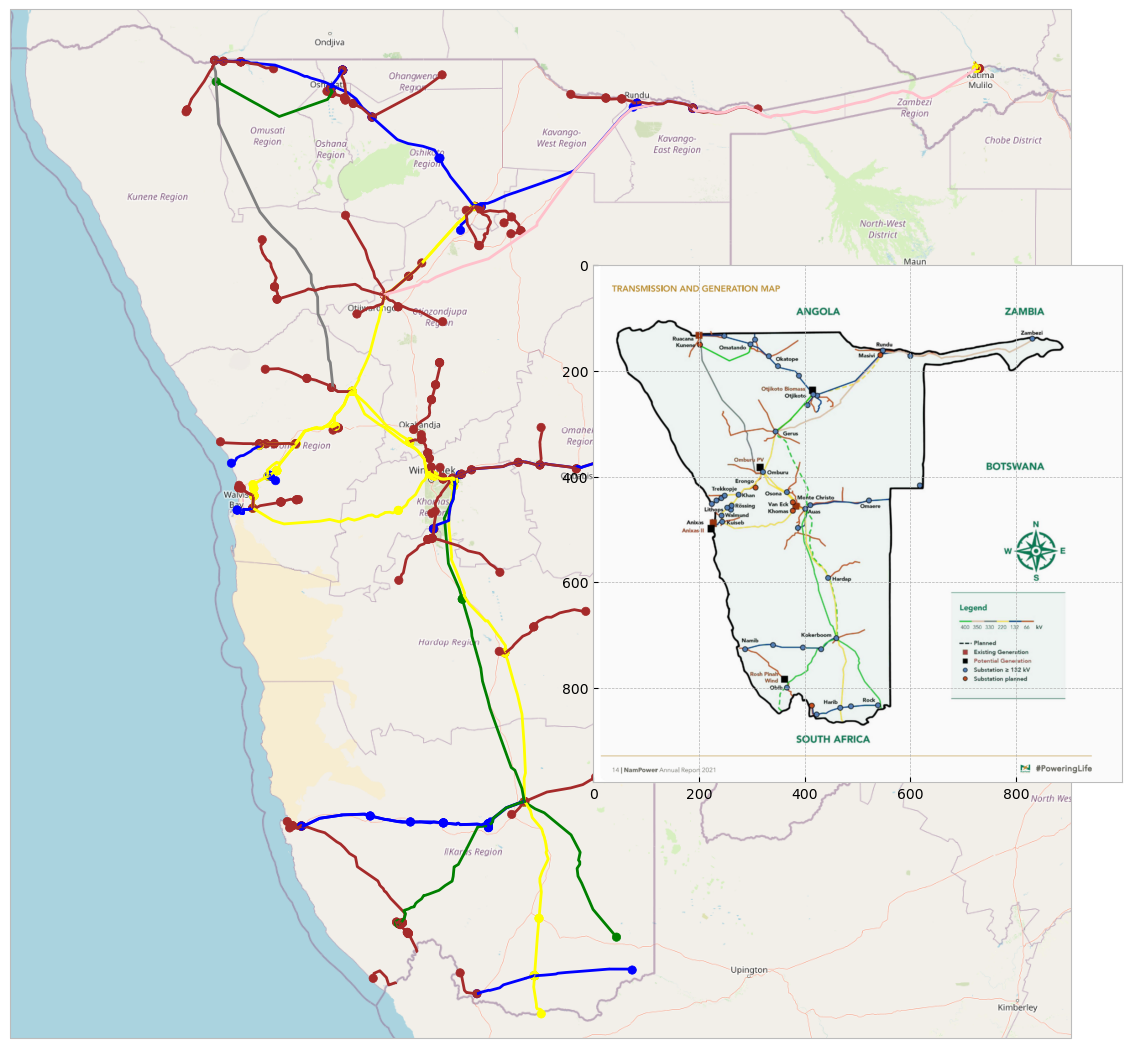

In [7]:
# get all country shapes
country_shapes = gpd.read_file(countries_shape_path)

# get namibia shape
namibia_shape = country_shapes.set_index("name").geometry

# add tolerance to bounds
tol = 0.2

bounds_mod = namibia_shape.boundary.bounds
bounds_mod["minx"] -= tol  # reduce minx
bounds_mod["miny"] -= tol  # reduce miny
bounds_mod["maxx"] += tol  # increase maxx
bounds_mod["maxy"] += tol  # increase maxy

# reorder bounds to comply with extend function (x0, x1, y0, y1)
extent_list = (
    float(bounds_mod["minx"]),
    float(bounds_mod["maxx"]),
    float(bounds_mod["miny"]),
    float(bounds_mod["maxy"]),
)
%matplotlib inline

# get the structure of the background data to plot
imagery = OSM()

max_width = 15  # max width of the figure
max_height = 15  # max height of the figure

# calculate figure size with appropriate multiplier to adhere to the desired width/height
multiplier = min(
    max_width / (extent_list[1] - extent_list[0]),
    max_height / (extent_list[3] - extent_list[2]),
)
figsize = (
    (extent_list[1] - extent_list[0]) * multiplier,
    (extent_list[3] - extent_list[2]) * multiplier,
)

# create an auxiliary dataframe for the substations with the desired crs and color properties
df_substations_osm_clean_plot = df_substations_clean_osm_namibia.to_crs(imagery.crs)
# specify the color of the nodes
df_substations_osm_clean_plot["color"] = df_substations_osm_clean_plot.voltage.apply(
    lambda x: voltage_to_color[x]
)

# create an auxiliary dataframe for the lines with the desired crs and properties
df_lines_osm_clean_plot = df_lines_clean_osm_namibia.to_crs(imagery.crs)
df_lines_osm_clean_plot[
    "centroids"
] = df_lines_osm_clean_plot.geometry.boundary.centroid  # get the centroids of the line
df_lines_osm_clean_plot["color"] = df_lines_osm_clean_plot.voltage.apply(
    lambda x: voltage_to_color[x]
) 

### 1.1.5 side by side comparison with local data source
max_width = 15  # max width of the figure
max_height = 15  # max height of the figure

img = plt.imread("../images/Namibia/Namibia_transmission_network_NamPower.png")

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1, 1, 1, projection=imagery.crs)  # specify projection
ax.set_extent(extent_list, ccrs.PlateCarree())  # specify the location of the image
ax.add_image(imagery, 7)  # add the background image

# draw the substations
df_substations_osm_clean_plot.plot(color=df_substations_osm_clean_plot.color, ax=ax)

# draw the lines
df_lines_osm_clean_plot.plot(color=df_lines_osm_clean_plot.color, ax=ax)

fig.add_subplot(1, 2, 2) 

imgplot = plt.imshow(img)
#plt.savefig("network-validation-namibia.pdf", bbox_inches='tight')


# """" uncomment  """" code under to see the plot without an overlaying map
""" 

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1, 1, 1, projection=imagery.crs)  # specify projection
ax.set_extent(extent_list, ccrs.PlateCarree())  # specify the location of the image
ax.add_image(imagery, 7)  # add the background image

# specify the color of the line

# draw the substations
df_substations_osm_clean_plot.plot(color=df_substations_osm_clean_plot.color, ax=ax)

"""

# draw the lines
df_lines_osm_clean_plot.plot(color=df_lines_osm_clean_plot.color, ax=ax)

# add annotations to show the number of circuits by line
for (id, row) in df_lines_osm_clean_plot.iterrows():
    ax.text(row.centroids.x, row.centroids.y, row.circuits, color=row.color)




#### 1.1.1 Comments on the network layout
A side-by-side comparison of transmission infrastructure from processed open street map data and data from Namibian public power utility company [NamPower](https://www.nampower.com.na/public/docs/annual-reports/NamPower%20Annual%20Report%202021.pdf) (page: 14). 

### 1.2 Calculate the total length of the lines

In this section, the total length of the lines are validated with data from different sources. 


#### 2. Network length information

- The line length is given by voltage level in [km]. 

- When multiple circuits are available, the length of the line is multiplied accordingly. 
- The World Bank data does not include directly circuit information, however, 
since maps sometimes show lines in parallel some circuits are included.

Note: the OSM dataset reports the geometry paths of the lines; 
however, in the same geometry path there may multiple circuits. 
That information is contained in the number of cables for geometry line, 

#### 1.2.1 Preliminary data loading of raw  and clean OSM data

In the following, we process the input data downloaded from OSM; the clean data have already been loaded and processed further.

In [8]:

# load substation geodataframe
df_substations_osm_raw_namibia = gpd.read_file(substations_OSMraw_path)
# load lines geodataframe
df_lines_raw_osm_namibia = gpd.read_file(lines_OSMraw_path)
# note that epsg=3857 has been chosen so that lenghts are in meters

###line data from raw open street map
df_lines_raw_osm_namibia["cables_fix"] = df_lines_raw_osm_namibia["tags.cables"].copy()
df_lines_raw_osm_namibia.loc[
    df_lines_raw_osm_namibia["tags.cables"].isnull()
    | df_lines_raw_osm_namibia["tags.cables"].isna(),
    "cables_fix",
] = 3  # when NaN or None, set default value
df_lines_raw_osm_namibia["length_km"] = (
    df_lines_raw_osm_namibia.to_crs(epsg=3857).geometry.length
    * df_lines_raw_osm_namibia["cables_fix"].astype(float)
    / 3
)

length_raw_osm = (
    df_lines_raw_osm_namibia.groupby(by=["tags.voltage"]).length_km.sum() / 1000
)
voltage = pd.to_numeric(
    pd.DataFrame(length_raw_osm).reset_index()["tags.voltage"], errors="coerce"
)
df_lines_raw_osm_namibia = pd.DataFrame(length_raw_osm)
df_lines_raw_osm_namibia.index = voltage

df = df_lines_raw_osm_namibia
osm_raw_lengths = calculatelength(df, "Open Street Map (raw")


### line data from clean open street map
df = df_lines_clean_osm_namibia

df["length"] = df.to_crs(epsg=3857).geometry.length * df.circuits / 1000
voltage = df.groupby(by=["voltage"]).length.sum()
df_clean_osm = pd.DataFrame(voltage)
osm_clean_lengths = pd.DataFrame()
df = df_clean_osm

osm_clean_lengths = calculatelength(df, "Open Street Map (clean)")




#### 1.2.2 World Bank Data

for more details, please refer to : https://energydata.info/dataset/africa-electricity-transmission-and-distribution-grid-map-2017 



In [9]:
#World Bank

url = "https://development-data-hub-s3-public.s3.amazonaws.com/ddhfiles/144823/africagrid20170906final.geojson"
df_lines_world_bank = gpd.read_file(url).to_crs(epsg=3857)
values = ["Jordan", "Syria", "Lebanon", "Iraq", "Saudi Arabia", "Oman", "Yemen"]
df_lines_world_bank = df_lines_world_bank[
    df_lines_world_bank.country.isin(values) == False
]
df_lines_world_bank_existing = df_lines_world_bank[
    df_lines_world_bank.status == "Existing"
]
df_lines_world_bank_planned = df_lines_world_bank[
    df_lines_world_bank.status == "Planned"
]
df_lines_world_bank_existing_namibia = df_lines_world_bank_existing[
    df_lines_world_bank_existing.country == "Namibia"
]

### line data from World Bank
namibia_length = df_lines_world_bank_existing_namibia
namibia_length["voltage_kV"] = namibia_length["voltage_kV"].astype(int)
#namibia_length["length_km_epsg3857"] = namibia_length.geometry.length / 1000
namibia_length["length_km"] = namibia_length["length_km"].astype(int)

df = namibia_length.groupby(by=["voltage_kV"]).sum()
df.index = df.index * 1000
world_bank_lengths= calculatelength(df, "world bank")

/home/raj08555/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/raj08555/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipykernel_25364/3786356838.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, nu

#### 1.2.3 NamPower

According to ([NamPower](https://www.nampower.com.na/public/docs/annual-reports/NamPower%20Annual%20Report%202021.pdf) p.16, 2021), here are the transmission lines length (km).
- 400 kV - 1179 km
- 350 kV - 953 km
- 330 kV - 522 km
- 220 kV - 3207 km 
- 132 kV - 2264 km
- 66  kV - 3575 km

A combine table summarized for all network lengths.

In [27]:
### NamPower transmission length data 2021
nampower_lengths = pd.DataFrame({"66kV" : [3575],"132kV": [2264], "220kV": [3207], "330kV": [522], 
"350kV": [953], "400kV": [1179],"scope": ["Namibia"],"reference": ["NamPower"]})
nampower_lengths.rename(index={0: 'length_km'})
#nampower_lengths.index
all_lengths = pd.concat([world_bank_lengths,osm_raw_lengths,osm_clean_lengths, nampower_lengths])
all_lengths

,66kV,132kV,220kV,330kV,350kV,400kV,scope,reference
length_km,3575,2264,3207,522,953,1179,Namibia,NamPower


## 2. Analysis on the demand data

According to [IEA](https://www.iea.org/countries/namibia#overview) The total electricity demand in 2013 and in 2020 was 3.8 TWh

Let's verify the input used in pypsa-earth.

#### Load the model

In [12]:
n_solve = pypsa.Network(solved_network_path)

INFO:pypsa.io:Imported network elec_s_32_ec_lcopt_Co2L-1H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


In [21]:
# filter only Namibian demand
namibia_demand = n_solve.loads_t.p.filter(regex="NA *", axis=1)
#print(namibia_demand)
# raw sum used in the model todo: 
tot_yearly_demand_scaled = namibia_demand.sum().sum()
#print(tot_yearly_demand_scaled)
# rescaled value accounting for the number of representative days: the factor (8760/namibia_demand.shape[0]) is the multiplier
tot_yearly_demand = tot_yearly_demand_scaled * 8760 / namibia_demand.shape[0]

# show value in TWh
print("Demand in TWh: %.2f" % (tot_yearly_demand / 1000000))

Demand in TWh: 6.28


#### Comments on the demand
Demand found to be significantly higher (+65%) than the demand portrayed in the looked resources. Further insights might be required.

## 3. Installed generation by type

In the subsequent section, the total installed generation is compared to validate the model.

According to [USAID](https://www.usaid.gov/powerafrica/namibia), the total installed generation in Namibia is:

- Coal: 122 MW
- Thermal (Gas, HFO, Diesel): 41 MW
- Wind: 7 MW
- Hydro: 347 MW
- Solar: 163 MW

Installed Capacity: 680 MW

After apllying required filters, the follow data output is found in pypsa-earth

In [66]:
# filter only generators in Nigeria
namibia_generators = n_solve.generators.filter(regex="NA *", axis=0)
total_cap = 0
# obtain installed generation by carrier
capacity_per_carrier = namibia_generators.groupby(by="carrier")["p_nom"].sum()
for c, group in namibia_generators.groupby(by="carrier"):
    print( c ,"    ", group["p_nom"].sum() , "MW")
    total_cap=total_cap + group["p_nom"].sum()
print( " \n Total  Capacity", total_cap - 32000000000 , "MW")

coal      110.63243478758092 MW
load      32000000000.0 MW
oil      58.01418868337344 MW
onwind      2.104263978810863 MW
ror      213.7791478246421 MW
solar      143.59369882138827 MW
 
 Total  Capacity 528.1237335205078 MW


#### Comments on the Generation
- Coal powered generation is found to be slightly lower (-9%) than reffered data.
- Thermal generation has higher capacity (+40%) in pypsa-earth.
- wind energy generation found only for onshore with 30% of current capacity in the reffered data.
- Hydro power, mostly coming from run-off-river is 60% higher in the reffered data.
- solar energy has been only 13% higher capacity in the reffered data.

Overall, the generation has 22% higher capacity in resource referred above.


#### Solved network

Index(['biomass', 'OCGT', 'nuclear', 'solar', 'geothermal', 'coal', 'CCGT',
       'oil', 'onwind', 'offwind-dc', 'lignite', 'offwind-ac', 'hydro', 'PHS',
       'ror', 'H2', 'battery'],
      dtype='object', name='Carrier')


/home/raj08555/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/plot.py:259: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, ratio in ratios.iteritems():


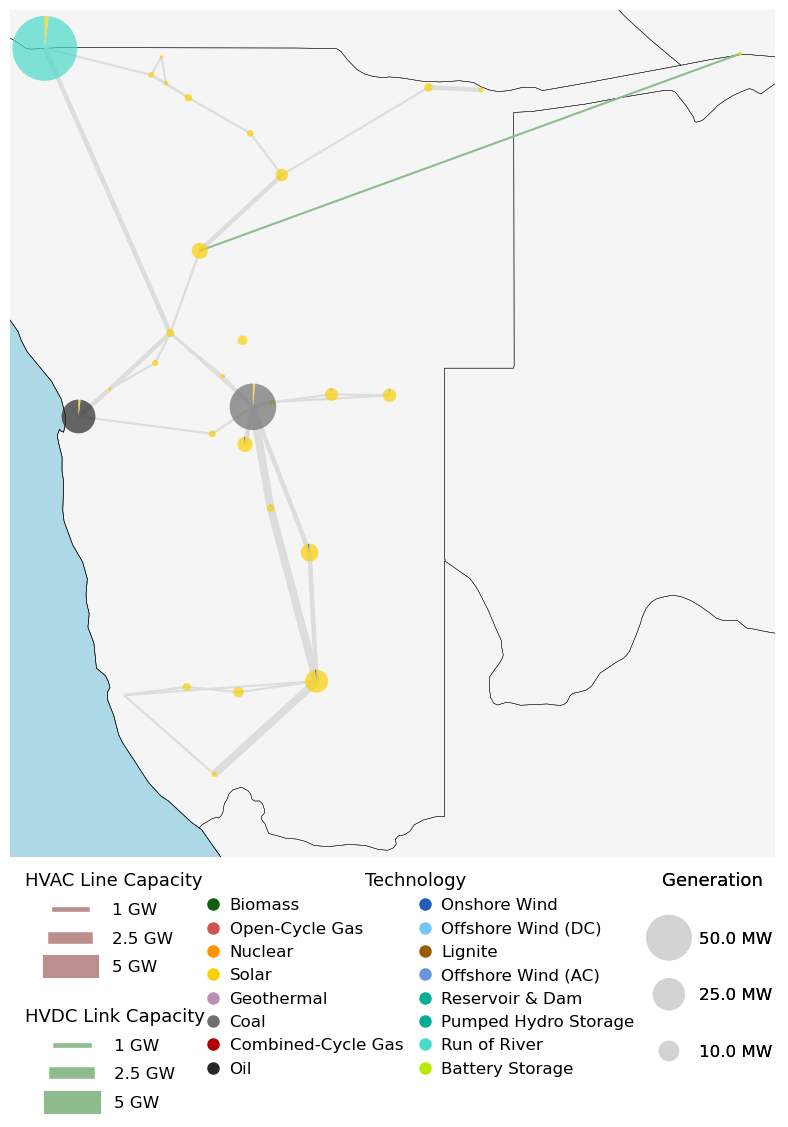

In [56]:
#n_solve.plot()
n=n_solve
#print(n.carriers.index)  
#plot_network(n, "network-solved-namibia.pdf")
plot_network(n)

## 4. Energy production shares

In the following, the total energy production shares as output of the total energy dispatch as available by IEA are compared to those calculated by the pypsa-earth procedure.

The following image depicts the energy demand by source as computed in the Stated Policy Scenarios by [IEA](https://www.iea.org/countries/namibia), which is used as a reference for comparison purposes

- Coal	 :   56 GWh 
- Oil	 :   9 GWh 
- Wind : 18 GWh
- Hydro	 :  1505 GWh 
- Solar PV : 369 GWh 



In [87]:
# filter only generators in Namibia
namibia_generators_dispatch = n_solve.generators_t.p.filter(regex="NA *", axis=1).copy()

# rename column to keep only the carrier
namibia_generators_dispatch.rename(
    columns=dict(
        zip(
            namibia_generators_dispatch.columns,
            map(
                lambda x: re.sub(r"NA \d+ ", "", x), namibia_generators_dispatch.columns
            ),
        )
    ),
    inplace=True,
)

# obtain generation by carrier
(
    namibia_generators_dispatch.groupby(level=0, axis=1).sum().sum()
    * 8760
    / namibia_generators_dispatch.shape[0]
    / 1000
).head(5)

# create empty DataFrame with specific column names & types
df = pd.DataFrame(
    {
        "carrier": pd.Series(dtype="str"),
        "pypsa_generation [GWh]": pd.Series(dtype="float"),
    }
)

carrier_list = n_solve.generators.carrier.unique()

for i in range(0, len(carrier_list)):
    df.loc[i] = [
        carrier_list[i],
        round(
            n_solve.generators_t.p.filter(like=carrier_list[i], axis=1).sum().sum()
            / 1000,
            2,
        ),
    ]  # MWh to GWh

iea_gen = pd.DataFrame()
iea_gen['carrier'] = ["onwind" ,"solar", "oil", "coal", "ror"]
iea_gen['gen_iea_GWh'] = [18, 369, 9, 56, 1505]
all_gen = pd.concat([df,iea_gen], axis=1, join="inner")
all_gen

,carrier,pypsa_generation [GWh],carrier,gen_iea_GWh
0,onwind,1319.39,onwind,18
1,solar,2678.69,solar,369
2,oil,74.19,oil,9
3,coal,691.39,coal,56
4,ror,1872.68,ror,1505
